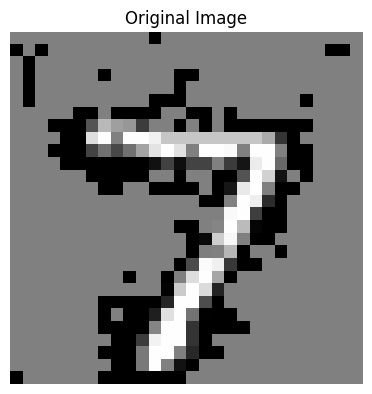

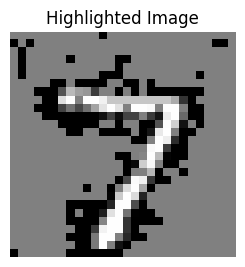

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
# Define the transformation for the image dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

# Define a simple CNN model for image classification
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train the model on each client's data and save the weights
epochs = 20
criterion = nn.CrossEntropyLoss()

def train_model(model, trainloader, epochs, criterion):
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    return model

# Train the model
model = SimpleCNN()
trained_model = train_model(model, trainloader, epochs, criterion)

# Function to get the top 30% contributing pixels
def get_top_contributing_pixels(model, data, percentage=0.3):
    model.eval()
    data.requires_grad_()
    output = model(data)
    pred_class = output.argmax(dim=1).item()

    model.zero_grad()
    output[0, pred_class].backward()
    grad = data.grad.abs().squeeze().detach().numpy()

    # Flatten the gradient array and get the threshold value
    flattened_grad = grad.flatten()
    threshold = np.percentile(flattened_grad, 100 - percentage * 100)

    # Create a mask of the top contributing pixels
    top_pixels_mask = grad >= threshold

    return top_pixels_mask

# Get a test image
test_images, _ = next(iter(testloader))
test_image = test_images[0].unsqueeze(0)

# Get the top 30% contributing pixels
top_pixels_mask = get_top_contributing_pixels(trained_model, test_image)
highlighted_image = test_image.squeeze().detach().numpy()  # tensor.detach().numpy()

# Convert the mask to coordinates
mask_2d = top_pixels_mask
highlighted_image[mask_2d == 0] = 0  # Mask non-top pixels

# Plot the original and highlighted image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(test_image.squeeze().detach().numpy(), cmap='gray')
plt.axis('off')
plt.savefig('Original_image.png', dpi=600)
plt.show()

plt.subplot(1, 2, 2)
plt.title("Highlighted Image")
plt.imshow(highlighted_image, cmap='gray')
plt.axis('off')
plt.savefig('Highlighted_Image.png', dpi=600)
plt.show()

# Configuration class
class Config:
    def __init__(self, dropout=0.5, learning_rate=0.001, num_epochs=50, batch_size=32):
        self.dropout = dropout
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size

# Base Model class (assuming you have this implemented)
class Model(nn.Module):
    def __init__(self, config, name):
        super(Model, self).__init__()
        self.config = config
        self.name = name

# FeatureNN class (assuming you have this implemented)
class FeatureNN(nn.Module):
    def __init__(self, config, name, input_shape, num_units, feature_num):
        super(FeatureNN, self).__init__()
        self.config = config
        self.name = name
        self.input_shape = input_shape
        self.num_units = num_units
        self.feature_num = feature_num
        self.fc = nn.Linear(input_shape, num_units)

    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        return x

# NAM model definition
class NAM(Model):
    def __init__(self, config, name, *, num_inputs: int, num_units: int) -> None:
        super(NAM, self).__init__(config, name)
        self._num_inputs = num_inputs
        self.dropout = nn.Dropout(p=self.config.dropout)

        if isinstance(num_units, list):
            assert len(num_units) == num_inputs
            self._num_units = num_units
        elif isinstance(num_units, int):
            self._num_units = [num_units for _ in range(self._num_inputs)]

        self.feature_nns = nn.ModuleList([
            FeatureNN(config=config, name=f'FeatureNN_{i}', input_shape=1, num_units=self._num_units[i], feature_num=i)
            for i in range(num_inputs)
        ])

        self.output_layer = nn.Linear(sum(self._num_units), 10)  # 10 classes for MNIST dataset
        self._bias = torch.nn.Parameter(data=torch.zeros(1))

    def calc_outputs(self, inputs: torch.Tensor) -> torch.Tensor:
        return [self.feature_nns[i](inputs[:, i:i+1]) for i in range(self._num_inputs)]

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        individual_outputs = self.calc_outputs(inputs)
        conc_out = torch.cat(individual_outputs, dim=-1)
        dropout_out = self.dropout(conc_out)
        out = self.output_layer(dropout_out)
        return out, dropout_out

    def print_model_equation(self, feature_names):
        equation_terms = []
        feature_contributions = {}
        for i, fnn in enumerate(self.feature_nns):
            coefficients = fnn.fc.weight.data.flatten().tolist()
            intercepts = fnn.fc.bias.data.tolist()
            term = " + ".join([f"({coeff:.3f} * x_{feature_names[i]} + {intercept:.3f})" for coeff, intercept in zip(coefficients, intercepts)])
            equation_terms.append(term)
            feature_contributions[feature_names[i]] = sum(abs(c) for c in coefficients)
        equation = " + ".join(equation_terms) + f" + bias ({self._bias.item():.3f})"
        print(f"Model Equation: y = {equation}")

        # Determine feature interpretability based on coefficients
        interpretability = sorted(feature_contributions.items(), key=lambda x: x[1], reverse=True)
        print("\nFeature Contributions:")
        for feature, contribution in interpretability:
            print(f"{feature}: {contribution:.3f}")

        return interpretability[0][0]  # Return the feature with the highest contribution

# Define the config
config = Config(dropout=0.5, learning_rate=0.001, num_epochs=50, batch_size=32)

# Instantiate the NAM model
num_inputs = 28 * 28  # Number of features for MNIST images
num_units = 10  # Number of units in the hidden layer
nam_model = NAM(config=config, name='NAM_Model', num_inputs=num_inputs, num_units=num_units)

# Training function for NAM model
def train_nam_model(model, trainloader, config):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    model.train()
    for epoch in range(config.num_epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs, _ = model(inputs.view(inputs.size(0), -1))  # Flatten the inputs
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{config.num_epochs}], Loss: {running_loss / len(trainloader):.4f}')
    return model

# Train the NAM model
trained_nam_model = train_nam_model(nam_model, trainloader, config)

# Evaluate the NAM model
def evaluate_nam_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs, _ = model(inputs.view(inputs.size(0), -1))  # Flatten the inputs
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Accuracy: {accuracy * 100:.2f}%')

evaluate_nam_model(trained_nam_model, testloader)

# Print the model equation and get the most contributing feature
feature_names = [f'pixel_{i}' for i in range(num_inputs)]
most_contributing_feature = trained_nam_model.print_model_equation(feature_names)
print(f"\nMost contributing feature: {most_contributing_feature}")
